In [ ]:
! pip install langgraph langchain-community pypdf faiss-cpu sentence-transformers langchain-groq

In [1]:
from langgraph.graph import StateGraph, END
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from typing import List, TypedDict
import os

In [9]:
from dotenv import load_dotenv
load_dotenv()

True

In [23]:
from langgraph.graph import StateGraph, END
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from typing import List, TypedDict
import os

# Configuration
PDF_PATH = "/content/your_pdfs_directory/Sakil_Resume.pdf"
INDEX_NAME = "faiss_resume_index"

# 1. Create Vector Store
def create_resume_index():
    loader = PyPDFLoader(PDF_PATH)
    pages = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )
    splits = text_splitter.split_documents(pages)

    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )

    vectorstore = FAISS.from_documents(splits, embeddings)
    vectorstore.save_local(INDEX_NAME)
    return vectorstore

# 2. Load Index
def load_resume_index():
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )

    if not os.path.exists(f"{INDEX_NAME}/index.faiss"):
        return create_resume_index()

    return FAISS.load_local(
        folder_path=INDEX_NAME,
        embeddings=embeddings,
        allow_dangerous_deserialization=True
    )

# 3. Initialize Components
vectorstore = load_resume_index()
llm = ChatGroq(temperature=0, model_name="deepseek-r1-distill-llama-70b")

class AnalystReview:
    def __init__(self, llm):
        self.llm = llm
        self.grading_prompt = ChatPromptTemplate.from_template(
            """Analyze the answer based on the resume:
            Question: {question}
            Context: {context}
            Answer: {answer}

            Should this answer be approved? Respond only with Yes/No."""
        )

    def grade(self, question: str, context: List[Document], answer: str) -> str:
        chain = self.grading_prompt | self.llm
        result = chain.invoke({
            "question": question,
            "context": "\n".join([doc.page_content for doc in context]),
            "answer": answer
        })
        return result.content.strip().split()[0]

# 4. Define Nodes
def retrieve_documents(state: WorkflowState):
    docs = vectorstore.similarity_search(state["question"], k=3)
    return {"context": docs}

def generate_answer(state: WorkflowState):
    context_str = "\n".join([doc.page_content for doc in state["context"]])
    response = llm.invoke(f"""
        Answer based on this resume content:
        {context_str}

        Question: {state["question"]}

        If the answer is  in the resume, say 'Yes' else 'Not mentioned'."""
    )
    return {"answer": response.content}

def grade_answer(state: WorkflowState):
    grade = AnalystReview(llm).grade(
        state["question"],
        state["context"],
        state["answer"]
    )
    return {"grade": grade}

# 5. Build Workflow
class WorkflowState(TypedDict):
    question: str
    context: List[Document]
    answer: str
    grade: str

workflow = StateGraph(WorkflowState)
workflow.add_node("retriever", retrieve_documents)
workflow.add_node("generator", generate_answer)
workflow.add_node("grader", grade_answer)

workflow.set_entry_point("retriever")
workflow.add_edge("retriever", "generator")
workflow.add_edge("generator", "grader")
workflow.add_edge("grader", END)

app = workflow.compile()


# 6. Query Function
def ask_question(question: str):
    result = app.invoke({"question": question})
    return {
        "question": question,
        "answer": result["answer"],
        "grade": result["grade"],
        "sources": [doc.metadata.get('source', '') for doc in result["context"]]
    }

# Example Usage
if __name__ == "__main__":
    response = ask_question("What are hobbies?.")
    print(f"Answer: {response['answer']}")
    print(f"Grade: {response['grade']}")
    print(f"Sources: {response['sources']}")

Answer: <think>
Okay, so I need to figure out if the resume mentions any hobbies. Let me go through the resume content provided step by step.

First, I'll look at the different sections. The resume starts with some technical skills like converting epoch to a readable date and storing data in databases using Python. Then there are links to the portfolio, GitHub, and LinkedIn. 

Next, there's a section on Leadership and Awards. It talks about helping get free education for backward communities, an award from L&T Technology Services, being a mentor in the KaggleX BIPOC Mentorship Program, and heading the Research in AI Community. These are all professional achievements and don't mention hobbies.

Then there's the contact information, which is just the address, phone number, and email. No hobbies there.

The Relevant Work Summary section details experience in data science, machine learning, NLP, and using various tools and libraries. Again, this is all professional experience, not hobbies.

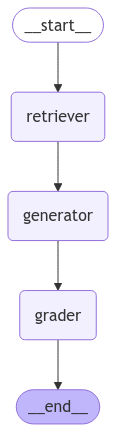

In [22]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass